# Summary 
In this notebook, I do some further cleaning such as keeping only columns used for modeling and removing rows with significant missing data. I replaced placeholder values with nulls to visualize the distributions of the new weather data with simple box plots. Finally, I hold out two separate test sets to see how well my models will generalize. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, StratifiedKFold

pd.set_option('display.max_columns', 50)

In [2]:
full = pd.read_pickle('dec_4_fires_joined_3weather_days.pkl')

In [3]:
full.shape

(1880443, 80)

In [4]:
full.columns

Index(['FOD_ID', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'FIRE_SIZE_CLASS',
       'LATITUDE', 'LONGITUDE', 'STATE', 'Month', 'DayofWeek',
       'DISCOVERY_TIME2', 'COUNTY2_x', 'COUNTY_ID', 'CLASS', 'StateID',
       'CAUSE', 'Prev_Lightning_Fires', 'Prev_Accident_Fires',
       'Prev_Arson_Fires', 'Prev_Other_Fires', 'Prev_Fires_at_Location',
       'Prev_Fires_Same_Month', 'Prev_1_fires2', 'Prev_2_Fires',
       'Prev_3_fires', 'Elevation', 'date_as_int', 'weather_station',
       'weather_station1', 'weather_station2', 'weather_station3', 'stn_x',
       'year_x', 'mo_x', 'da_x', 'temp_x', 'stp_x', 'wdsp_x', 'max_temp_x',
       'prcp_x', 'thunder_x', 'date_x', 'stn_y', 'year_y', 'mo_y', 'da_y',
       'temp_y', 'stp_y', 'wdsp_y', 'max_temp_y', 'prcp_y', 'thunder_y',
       'date_y', 'stn', 'year', 'mo', 'da', 'temp', 'stp', 'wdsp', 'max_temp',
       'prcp', 'thunder', 'date', 'day_2', 'day_3', 'stn_day2', 'ye

In [5]:
# reduce size of data keep only columns useful for modeling
full = full[['FOD_ID', 'DISCOVERY_DATE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS',
       'LATITUDE', 'LONGITUDE', 'Month', 'DayofWeek',
       'COUNTY2_x', 'COUNTY_ID', 'CLASS', 'StateID',
       'Elevation', 
       'weather_station1', 'stn_x',
       'year_x', 'temp_x', 'stp_x', 'wdsp_x', 'max_temp_x',
       'prcp_x', 'thunder_x', 'date_x', 'day_2', 'year_day2',
       'temp_day2', 'stp_day2', 'wdsp_day2',
       'max_temp_day2', 'prcp_day2', 'thunder_day2', 'date_day2']]

In [6]:
full.shape

(1880443, 32)

# Cleaning

### Remove fires where stations didn't have a match in GBQ on the date

In [7]:
full['max_temp_x'].isnull().sum()

287733

In [8]:
full['wdsp_x'].isnull().sum()

287733

In [9]:
# same number of rows suggest these are the same fires
full[(full['max_temp_x'].isnull()) & (full['wdsp_x'].isnull())].shape

(287733, 32)

In [10]:
# confirm that station weather is missing
full[(full['max_temp_x'].isnull()) & (full['wdsp_x'].isnull())].head()

,FOD_ID,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,Month,DayofWeek,COUNTY2_x,COUNTY_ID,CLASS,StateID,Elevation,weather_station1,stn_x,year_x,temp_x,stp_x,wdsp_x,max_temp_x,prcp_x,thunder_x,date_x,day_2,year_day2,temp_day2,stp_day2,wdsp_day2,max_temp_day2,prcp_day2,thunder_day2,date_day2
4,1100722,1992-01-01,8.00,B,29.540000,-83.210000,1,Wednesday,dixie,12029,1,12,7,722120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
23,768539,1992-01-01,3.00,B,31.253466,-89.278238,1,Wednesday,forrest,28035,1,28,74,722347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
24,1089208,1992-01-01,1.00,B,27.410000,-81.430000,1,Wednesday,highlands,12055,1,12,26,749045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
26,19112201,1992-01-01,0.07,A,31.755100,-81.653500,1,Wednesday,long,13183,1,13,25,722090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1992-01-02,1992,57.5,9999.9,5.8,64.0,0.01,0,1992-01-02
28,19077872,1992-01-01,4.40,B,32.509300,-81.708600,1,Wednesday,bulloch,13031,1,13,58,692704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [12]:
match = full[~(full['max_temp_x'].isnull())]
print(match.shape[0])
nomatch = full[full['max_temp_x'].isnull()]
print(nomatch.shape[0])


1592710
287733


#### Check if there's the removed fires are much different than the remaining fires.

In [13]:
match['FIRE_SIZE_CLASS'].value_counts() / len(match)

B    0.506544
A    0.349035
C    0.116784
D    0.014743
E    0.007159
F    0.003870
G    0.001864
Name: FIRE_SIZE_CLASS, dtype: float64

In [14]:
nomatch['FIRE_SIZE_CLASS'].value_counts() / len(nomatch)

B    0.460820
A    0.385747
C    0.118419
D    0.017186
E    0.009398
F    0.005637
G    0.002794
Name: FIRE_SIZE_CLASS, dtype: float64

In [15]:
match['CLASS'].value_counts() / len(match)

1    0.874481
2    0.120020
3    0.005499
Name: CLASS, dtype: float64

In [16]:
nomatch['CLASS'].value_counts() / len(nomatch)

1    0.864322
2    0.127584
3    0.008094
Name: CLASS, dtype: float64

In [17]:
# # More matches in recent years, and fairly even overall
nomatch['DISCOVERY_DATE'].dt.year.value_counts().sort_index() / len(nomatch)

1992    0.047909
1993    0.039005
1994    0.047760
1995    0.046474
1996    0.059430
1997    0.043502
1998    0.041514
1999    0.050178
2000    0.051211
2001    0.039676
2002    0.031762
2003    0.030688
2004    0.037232
2005    0.052789
2006    0.056671
2007    0.051701
2008    0.044124
2009    0.037948
2010    0.036777
2011    0.037785
2012    0.031286
2013    0.027831
2014    0.030083
2015    0.026664
Name: DISCOVERY_DATE, dtype: float64

The classes of the fires without a matching station are about the same as the ones that do, so dropping them from the data should not bias the remaining data for classification. 

However, fire size itself has a different distribution, something to keep in mind if I try to use regression to predict the size instead.

In [18]:
match['FIRE_SIZE'].describe()

count    1.592710e+06
mean     6.838595e+01
std      2.368937e+03
min      1.000000e-05
25%      1.000000e-01
50%      1.000000e+00
75%      3.260000e+00
max      6.069450e+05
Name: FIRE_SIZE, dtype: float64

In [19]:
nomatch['FIRE_SIZE'].describe()

count    287733.000000
mean        108.480889
std        3114.968395
min           0.000090
25%           0.100000
50%           0.750000
75%           3.400000
max      499945.000000
Name: FIRE_SIZE, dtype: float64

In [20]:
nomatch[nomatch['FIRE_SIZE'] == 499945]

,FOD_ID,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,Month,DayofWeek,COUNTY2_x,COUNTY_ID,CLASS,StateID,Elevation,weather_station1,stn_x,year_x,temp_x,stp_x,wdsp_x,max_temp_x,prcp_x,thunder_x,date_x,day_2,year_day2,temp_day2,stp_day2,wdsp_day2,max_temp_day2,prcp_day2,thunder_day2,date_day2
50865,155225,2002-07-13,499945.0,G,42.038889,-123.911667,7,Saturday,curry,41015,3,41,731,725985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2002-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [21]:
# having weather on day 1 doesn't guarantee day 2
match[match['max_temp_day2'].isnull()].head()

,FOD_ID,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,Month,DayofWeek,COUNTY2_x,COUNTY_ID,CLASS,StateID,Elevation,weather_station1,stn_x,year_x,temp_x,stp_x,wdsp_x,max_temp_x,prcp_x,thunder_x,date_x,day_2,year_day2,temp_day2,stp_day2,wdsp_day2,max_temp_day2,prcp_day2,thunder_day2,date_day2
163,180889,1992-01-02,20.5,C,45.275000,-100.767100,1,Thursday,dewey,46041,2,46,553,726685,726685,1992,28.8,9999.9,5.8,44.1,0.0,0,1992-01-02,1992-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
164,178859,1992-01-02,2.0,B,45.833300,-100.467100,1,Thursday,corson,46031,1,46,610,726685,726685,1992,28.8,9999.9,5.8,44.1,0.0,0,1992-01-02,1992-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
175,774493,1992-01-03,1.0,B,31.421469,-89.871791,1,Friday,jefferson davis,28065,1,28,104,722348,722348,1992,49.0,9999.9,3.6,55.0,0.0,0,1992-01-03,1992-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
177,775155,1992-01-03,1.0,B,31.216249,-89.804796,1,Friday,marion,28091,1,28,49,722348,722348,1992,49.0,9999.9,3.6,55.0,0.0,0,1992-01-03,1992-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
201,775154,1992-01-03,7.0,B,31.301370,-89.842104,1,Friday,marion,28091,1,28,63,722348,722348,1992,49.0,9999.9,3.6,55.0,0.0,0,1992-01-03,1992-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [22]:
# Check if data is simply unavailable or if there is a potential problem

In [23]:
w1992 = pd.read_pickle('./data/clean_weather1992.pkl')

In [24]:
w1992.head()

,stn,year,mo,da,temp,stp,wdsp,max_temp,prcp,thunder,date
9,690020,1992,01,02,49.1,9999.9,2.0,62.1,0.00,0,1992-01-02
20,690020,1992,01,03,50.0,9999.9,1.5,60.1,0.04,0,1992-01-03
12,690020,1992,01,06,47.0,9999.9,1.6,54.0,0.00,0,1992-01-06
15,690020,1992,01,07,48.1,9999.9,3.3,54.0,0.12,0,1992-01-07
3,690020,1992,01,08,46.6,9999.9,2.2,57.0,0.24,0,1992-01-08


In [25]:
# Jan 3 is missing from weather data
# Likely simply missing even though the date falls under the station's coverage
# Can try 2nd closest station, but < 20k out of 1.5 million
w1992[w1992['stn'] == '726685'].head()

,stn,year,mo,da,temp,stp,wdsp,max_temp,prcp,thunder,date
327903,726685,1992,01,02,28.8,9999.9,5.8,44.1,0.00,0,1992-01-02
327901,726685,1992,01,04,29.7,9999.9,13.4,41.0,0.00,0,1992-01-04
327916,726685,1992,01,05,34.2,9999.9,7.2,45.0,0.00,0,1992-01-05
327915,726685,1992,01,06,29.9,9999.9,8.2,48.0,0.00,0,1992-01-06
327921,726685,1992,01,07,30.4,9999.9,11.4,33.1,0.01,0,1992-01-07


### Convert continuous variables to floats

In [26]:
match.dtypes

FOD_ID                       int64
DISCOVERY_DATE      datetime64[ns]
FIRE_SIZE                  float64
FIRE_SIZE_CLASS             object
LATITUDE                   float64
LONGITUDE                  float64
Month                        int64
DayofWeek                   object
COUNTY2_x                   object
COUNTY_ID                   object
CLASS                     category
StateID                     object
Elevation                   object
weather_station1            object
stn_x                       object
year_x                      object
temp_x                     float64
stp_x                      float64
wdsp_x                      object
max_temp_x                 float64
prcp_x                     float64
thunder_x                   object
date_x              datetime64[ns]
day_2               datetime64[ns]
year_day2                   object
temp_day2                  float64
stp_day2                   float64
wdsp_day2                   object
max_temp_day2       

In [27]:
match['wdsp_x'] = match['wdsp_x'].astype('float')
match['Elevation'] = match['Elevation'].astype('float')
match['wdsp_day2'] = match['wdsp_day2'].astype('float')

/home/douglas/anaconda3/envs/dask-tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/douglas/anaconda3/envs/dask-tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/douglas/anaconda3/envs/dask-tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [52]:
# Replace placeholders as nulls for plotting
match['max_temp_x'].replace(9999.9, np.NaN, inplace=True)
match['wdsp_x'].replace(999.9, np.NaN, inplace=True)
match['prcp_x'].replace(99.99, np.NaN, inplace=True)

/home/douglas/anaconda3/envs/dask-tutorial/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [53]:
# average temp looks like it's all present
print(match['temp_x'].isnull().sum())
match['temp_x'].value_counts().sort_index(ascending=False).head()

0


109.9    4
109.1    2
108.9    2
108.7    1
108.6    6
Name: temp_x, dtype: int64

In [54]:
# standard pressure has a lot of missing values - may not be too useful
match['stp_x'].value_counts().sort_index(ascending=False).head()

9999.9    869784
1042.7         1
1041.9         1
1041.5         1
1041.4         1
Name: stp_x, dtype: int64

In [55]:
match['stp_x'].replace(9999.9, np.NaN, inplace=True)

In [56]:
# Repeat for day 2 
match['max_temp_day2'].replace(9999.9, np.NaN, inplace=True)
match['wdsp_day2'].replace(999.9, np.NaN, inplace=True)
match['prcp_day2'].replace(99.99, np.NaN, inplace=True)
match['stp_day2'].replace(9999.9, np.NaN, inplace=True)

In [57]:
# Summarize nulls
match.isnull().sum()

FOD_ID                   0
DISCOVERY_DATE           0
FIRE_SIZE                0
FIRE_SIZE_CLASS          0
LATITUDE                 0
LONGITUDE                0
Month                    0
DayofWeek                0
COUNTY2_x                0
COUNTY_ID                0
CLASS                    0
StateID                  0
Elevation                0
weather_station1         0
stn_x                    0
year_x                   0
temp_x                   0
stp_x               869784
wdsp_x                5338
max_temp_x            1341
prcp_x               56141
thunder_x                0
date_x                   0
day_2                    0
year_day2            14784
temp_day2            14784
stp_day2            872601
wdsp_day2            19844
max_temp_day2        16056
prcp_day2            97141
thunder_day2         14784
date_day2            14784
dtype: int64

# Boxplots 
Visualize the distributions of some of the new weather features

In [58]:
# len(match) is faster than match.shape[0]

In [59]:
def label_boxplot(feature, group, df):
    '''Plot box plot with auto generated but rough labels
    **Inputs**
    feature: str, name of column of interest
    group: str, name of column to group by
    df: df, the data'''
    plt.figure(figsize=(12,8))
    sns.boxplot(x=feature, y=group, data=df, order=sorted(df[group].unique()))
    plt.title(f'Distribution of {feature} for each size class', fontsize=16)
    plt.xlabel(f'{feature}')
    plt.ylabel('Fire size class')

In [60]:
match.groupby('FIRE_SIZE_CLASS')['max_temp_x'].describe()

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,555512.0,78.019684,15.220788,-13.0,68.0,80.1,89.6,127.4
B,806126.0,76.900003,14.872600,-54.4,66.2,77.9,88.0,126.0
C,185815.0,77.173318,14.511966,-4.0,68.0,77.0,88.0,122.0
D,23428.0,80.062127,14.857298,1.4,70.0,80.6,91.4,120.0
E,11380.0,82.316661,14.878194,-0.4,72.0,84.0,93.9,120.0
F,6145.0,85.678975,13.851376,1.9,77.0,88.0,96.1,126.0
G,2963.0,88.012555,12.186801,24.8,80.1,89.6,97.0,117.0


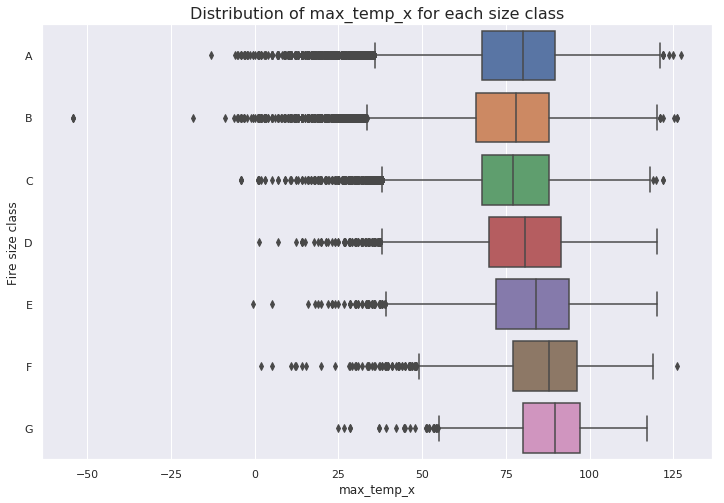

In [61]:
label_boxplot('max_temp_x', 'FIRE_SIZE_CLASS', match)
# max_temp is definitely a promising feature. 

CPU times: user 507 ms, sys: 35.3 ms, total: 542 ms
Wall time: 236 ms


(-3.6500000000000004, 30)

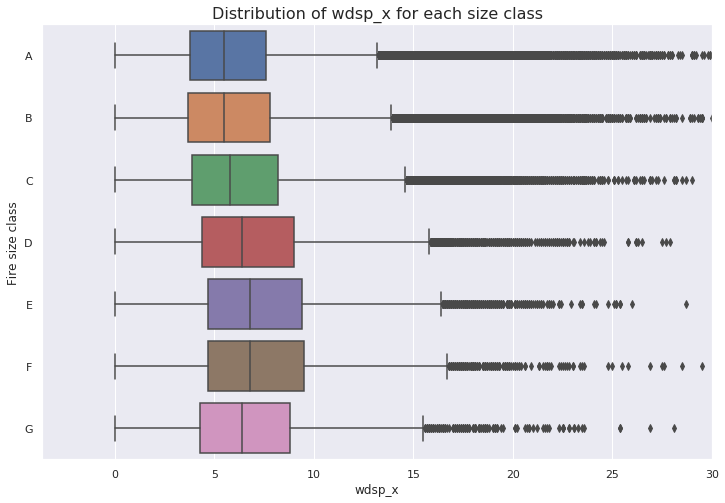

In [62]:
%time label_boxplot('wdsp_x', 'FIRE_SIZE_CLASS', match)
plt.xlim(right=30)
# wdsp might have some signal but highly variable

CPU times: user 330 ms, sys: 16.5 ms, total: 347 ms
Wall time: 125 ms


(-3.6500000000000004, 30)

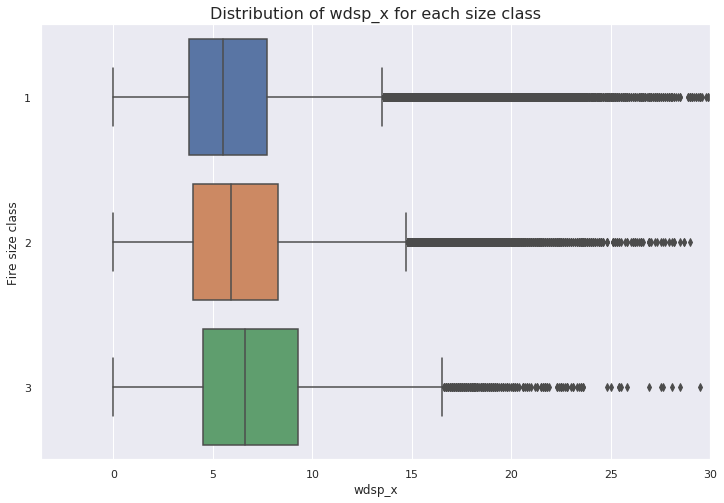

In [63]:
%time label_boxplot('wdsp_x', 'CLASS', match)
plt.xlim(right=30)
# see if bucketing into fewer classes help discern a pattern
# But not enough. Need 

In [64]:
match.groupby('FIRE_SIZE_CLASS')['wdsp_day2'].describe()

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,547271.0,5.981457,3.103290,0.0,3.8,5.5,7.6,59.0
B,797915.0,6.124073,3.208905,0.0,3.8,5.7,7.9,68.4
C,184220.0,6.454188,3.338044,0.0,4.0,6.0,8.4,46.8
D,23195.0,7.090157,3.640275,0.0,4.6,6.6,9.1,49.3
E,11264.0,7.406170,3.707948,0.0,4.8,6.9,9.4,36.8
F,6075.0,7.505070,3.878460,0.0,4.8,6.9,9.6,29.0
G,2926.0,7.243370,4.025121,0.0,4.5,6.5,9.3,36.8


CPU times: user 337 ms, sys: 7.49 ms, total: 345 ms
Wall time: 123 ms


(-3.4200000000000004, 30)

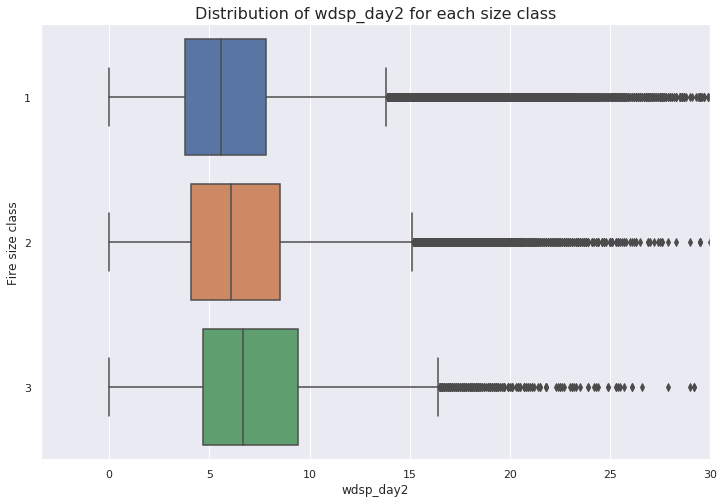

In [65]:
%time label_boxplot('wdsp_day2', 'CLASS', match)
plt.xlim(right=30)

In [66]:
match.groupby('FIRE_SIZE_CLASS')['prcp_x'].describe()
# if there's heavy rain, then only small fires possible,
# but lack of prcp doesn't imply big fire

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,533417.0,0.023697,0.138375,0.0,0.0,0.0,0.0,10.71
B,780833.0,0.015738,0.123550,0.0,0.0,0.0,0.0,12.12
C,179910.0,0.015473,0.133450,0.0,0.0,0.0,0.0,12.12
D,22609.0,0.013359,0.099770,0.0,0.0,0.0,0.0,3.24
E,10991.0,0.013990,0.093674,0.0,0.0,0.0,0.0,2.23
F,5943.0,0.015275,0.115025,0.0,0.0,0.0,0.0,4.05
G,2866.0,0.010914,0.066059,0.0,0.0,0.0,0.0,1.54


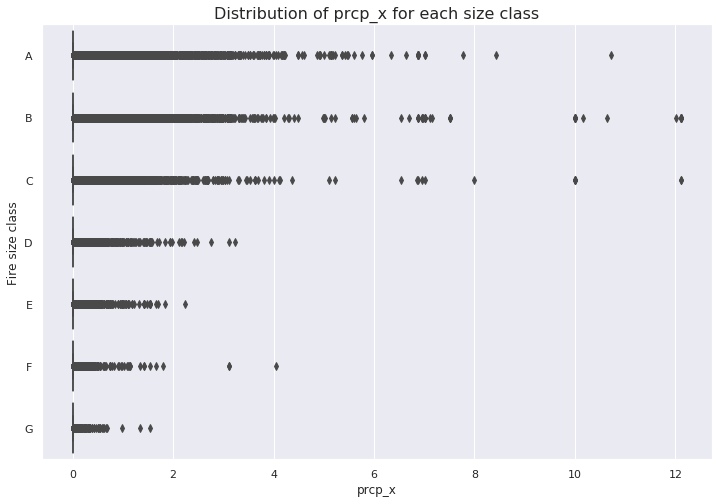

In [67]:
label_boxplot('prcp_x', 'FIRE_SIZE_CLASS', match)

In [68]:
def boxen_plot(feature, group, df):
    '''Plot box plot with auto generated but rough labels
    **Inputs**
    feature: str, name of column of interest
    group: str, name of column to group by
    df: df, the data'''
    plt.figure(figsize=(12,8))
    sns.catplot(x=feature, y=group, kind='boxen', data=df, order=sorted(df[group].unique()))
    plt.title(f'Distribution of {feature} for each size class', fontsize=16)
    plt.xlabel(f'{feature}')
    plt.ylabel('Fire size class')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

<Figure size 864x576 with 0 Axes>

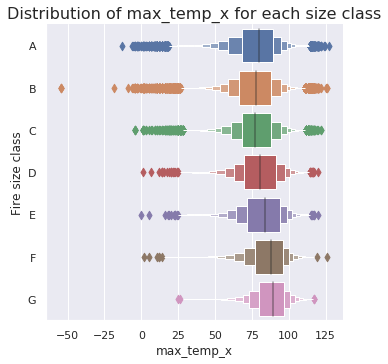

In [69]:
boxen_plot('max_temp_x', 'FIRE_SIZE_CLASS', match)

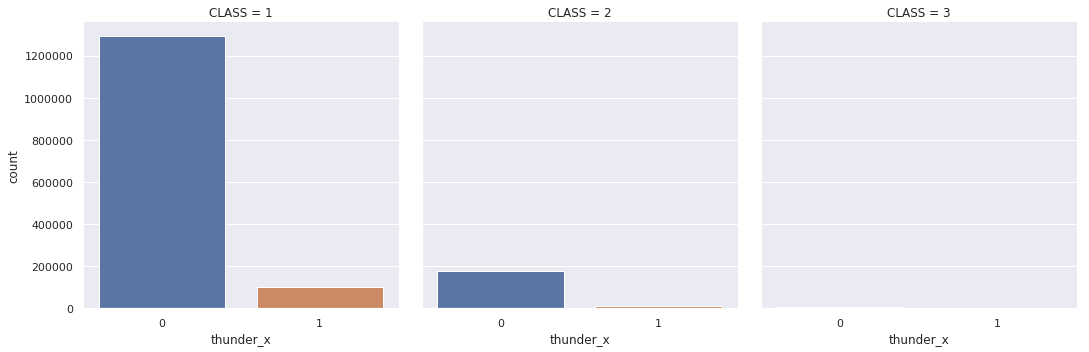

In [70]:
sns.catplot(x="thunder_x", kind="count", col='CLASS', data=match)

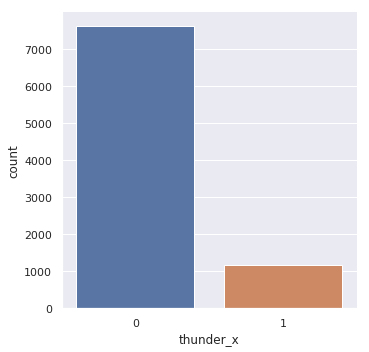

In [71]:
sns.catplot(x="thunder_x", kind="count", data=match[match['CLASS']==3])

In [72]:
thunder = match.groupby('FIRE_SIZE_CLASS')['thunder_x']\
               .value_counts()\
               .reset_index(name='count')\
               .pivot(index='FIRE_SIZE_CLASS', 
                      columns='thunder_x', 
                      values='count')

In [73]:
thunder['ratio'] = thunder.iloc[:,1]/thunder.iloc[:,0]
thunder

thunder_x,0,1,ratio
FIRE_SIZE_CLASS,,,
A,500437,55475,0.110853
B,764226,42551,0.055679
C,175335,10668,0.060844
D,21699,1783,0.082170
E,10324,1079,0.104514
F,5406,758,0.140215
G,2538,431,0.169819


In [74]:
match.groupby(['thunder_x', 'FIRE_SIZE_CLASS'])['prcp_x'].describe()
# thunder usually means more rain but no strong signals here

count      mean       std  min  25%  50%   75%  \
thunder_x FIRE_SIZE_CLASS                                                      
0         A                486646.0  0.015324  0.102862  0.0  0.0  0.0  0.00   
          B                745680.0  0.009999  0.096342  0.0  0.0  0.0  0.00   
          C                171236.0  0.009458  0.106830  0.0  0.0  0.0  0.00   
          D                 21151.0  0.007147  0.063612  0.0  0.0  0.0  0.00   
          E                 10078.0  0.008802  0.076023  0.0  0.0  0.0  0.00   
          F                  5288.0  0.010318  0.100943  0.0  0.0  0.0  0.00   
          G                  2506.0  0.006935  0.058507  0.0  0.0  0.0  0.00   
1         A                 46771.0  0.110816  0.316181  0.0  0.0  0.0  0.08   
          B                 35153.0  0.137494  0.355886  0.0  0.0  0.0  0.10   
          C                  8674.0  0.134222  0.359554  0.0  0.0  0.0  0.09   
          D                  1458.0  0.103477  0.295006  0.0  0.0  0.0  0.05   
          E                   913.0  0.071249  0.195705  0.0  0.0  0.0  0.03   
          F                   655.0  0.055298  0.189829  0.0  0.0  0.0  0.02   
          G                   360.0  0.038611  0.100305  0.0  0.0  0.0  0.02   

                             max  
thunder_x FIRE_SIZE_CLASS         
0         A                 7.78  
          B                12.12  
          C                12.12  
          D                 2.75  
          E                 1.70  
          F                 4.05  
          G                 1.54  
1         A                10.71  
          B                12.01  
          C                 7.99  
          D                 3.24  
          E                 2.23  
          F                 3.12  
          G                 0.68

In [75]:
match.shape

(1592710, 32)

# Hold out data sets
I hold out two samples of size 20000. The first, "recents", contains only fires from 2015, for a temporal test set. The second is sampled from the remaining fires using train_test_split from sklearn with the stratify option enabled to get the same distribution of fire size classes. The resulting datasets are all pickled for easy access. 

In [76]:
m2015 = match[match['DISCOVERY_DATE'].dt.year == 2015]

In [77]:
len(m2015)

66797

In [78]:
m2015['FIRE_SIZE_CLASS'].value_counts() / len(m2015)

A    0.437699
B    0.432415
C    0.100454
D    0.014147
E    0.007186
F    0.004312
G    0.003788
Name: FIRE_SIZE_CLASS, dtype: float64

In [79]:
match['FIRE_SIZE_CLASS'].value_counts() / len(match)

B    0.506544
A    0.349035
C    0.116784
D    0.014743
E    0.007159
F    0.003870
G    0.001864
Name: FIRE_SIZE_CLASS, dtype: float64

In [88]:
recents = m2015.sample(20000)

In [89]:
recents['FIRE_SIZE_CLASS'].value_counts() / 20000
# slightly different ratios but has a good amount of the rare classes

B    0.43590
A    0.43570
C    0.09935
D    0.01360
E    0.00705
F    0.00450
G    0.00390
Name: FIRE_SIZE_CLASS, dtype: float64

In [90]:
remaining = match[~match['FOD_ID'].isin(recents['FOD_ID'])]


In [91]:
# Alternative way to make sample- didn't use.
# evals = remaining.sample(20000)
# evals['FIRE_SIZE_CLASS'].value_counts() / 20000

B    0.49515
A    0.35580
C    0.12045
D    0.01615
E    0.00685
F    0.00400
G    0.00160
Name: FIRE_SIZE_CLASS, dtype: float64

In [92]:
train, val = train_test_split(remaining, test_size=20000, stratify=remaining['FIRE_SIZE_CLASS'])

In [93]:
val['FIRE_SIZE_CLASS'].value_counts() / 20000

B    0.50745
A    0.34795
C    0.11700
D    0.01475
E    0.00715
F    0.00385
G    0.00185
Name: FIRE_SIZE_CLASS, dtype: float64

In [94]:
val['DISCOVERY_DATE'].dt.year.value_counts()

2006    1192
2000    1044
2007    1043
2011    1039
1999     964
2001     949
2008     943
2010     903
2005     897
2002     844
2012     832
2009     823
2003     772
2004     765
1995     757
1994     749
1996     742
2013     732
1998     719
2014     692
1992     689
1993     651
1997     633
2015     626
Name: DISCOVERY_DATE, dtype: int64

In [95]:
recents.to_pickle('recent_fires20k.pkl')
train.to_pickle('train_fires.pkl')
val.to_pickle('val_fires20k.pkl')

# UNUSED CODE

In [ ]:
# tried dask
# overhead not worth it yet 

In [ ]:
# import dask.dataframe as dd
# dfull = dd.from_pandas(full, npartitions=7)

In [ ]:
# %time dfull['Elevation'].value_counts().compute().head()

In [ ]:
# %time full['Elevation'].value_counts().head()

In [ ]:
# %time dfull.count().compute()
# %time full.count()
# dash overhead takes quite a bit longer

In [ ]:
# import scipy.stats as stats

In [ ]:
# stats.ks_2samp(match['FIRE_SIZE'], nomatch['FIRE_SIZE'])